# $D_{s1}(2460)^+\to D_s^+\gamma$ production study
## Yields
### MonteCarlo analysis
#### Resolution distributions and fit templates

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



In [1]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd
import matplotlib.pyplot as plt
import os
ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
import RooPyFit as rpf
import RooPyShort as rsh

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()

%jsroot on

Welcome to JupyROOT 6.28/04
2024-02-20 18:17:26.478301
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
if not os.path.exists("./Graphs"):
    os.makedirs("./Graphs")
else:
    print("Graphs directory already exists")

if not os.path.exists("./Results"):
    os.makedirs("./Results")
else:
    print("Results directory already exists")

if not os.path.exists("./Tables"):
    os.makedirs("./Tables")
else:
    print("Tables directory already exists")

Graphs directory already exists
Results directory already exists
Tables directory already exists


## nTuples path

In [3]:
path_off = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/'
path_priv = "/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/"

dtt = "DsGammaTuple"

## MCMatching and selection

In [4]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]
TRUEID_Ds0_prb = TRUEID_dtt["Ds0DsPi0"]
TRUEID_Ds1_prb = TRUEID_dtt["Ds1DsstPi0"]
TRUEID_Dsst_prb = TRUEID_dtt["DsstDsPi0"]
TRUEID_Ds1_sig = TRUEID_dtt["Ds1DsGamma"]
TRUEID_Dsst_sig = TRUEID_dtt["DsstDsGamma"]

Ds_window = "abs(Ds_M - 1969) < 20"
gamma_cuts = "gamma_PT > 1200 && gamma_CL > 0.7"
nPVs_cut = "nPVs == 1"

sel = Ds_window+"&&"+gamma_cuts

## RooFit Models

### RooRealVar and initial parameters

In [5]:
m_reso = ROOT.RooRealVar("Dsg_RES_M_des", "Dsg_RES_M_des", -200, 250)

mu_c = 0
sigma_c = 15
alpha_c = 1
n_c = 4

### Crystal Ball model

 $$\mathrm{CB}\left(m ; m_0, \sigma, \alpha_L, n_L, \alpha_R, n_R\right)= \begin{cases}A_L \cdot\left(B_L-\frac{m-m_0}{\sigma_L}\right)^{-n_L}, & \text { for } \frac{m-m_0}{\sigma_L}<-\alpha_L \\ \exp \left(-\frac{1}{2} \cdot\left[\frac{m-m_0}{\sigma_L}\right]^2\right), & \text { for } \frac{m-m_0}{\sigma_L} \leq 0 \\ \exp \left(-\frac{1}{2} \cdot\left[\frac{m-m_0}{\sigma_R}\right]^2\right), & \text { for } \frac{m-m_0}{\sigma_R} \leq \alpha_R \\ A_R \cdot\left(B_R+\frac{m-m_0}{\sigma_R}\right)^{-n_R}, & \text { otherwise }\end{cases}$$




In [6]:
mu = ROOT.RooRealVar("mu", "mu", mu_c, mu_c-15, mu_c+15)
sigma = ROOT.RooRealVar("sigma", "sigma", sigma_c, 0.01*sigma_c, 3*sigma_c)
alphaL = ROOT.RooRealVar("alphaL", "alphaL", alpha_c, 0.01*alpha_c, 30*alpha_c)
nL = ROOT.RooRealVar("nL", "nL", n_c, 0, 100)
alphaR = ROOT.RooRealVar("alphaR", "alphaR", alpha_c, 0.01*alpha_c, 10*alpha_c)
nR = ROOT.RooRealVar("nR", "nR", n_c, 0, 100)

CB = ROOT.RooCrystalBall("CB", "CB", m_reso, mu, sigma, alphaL, nL, alphaR, nR)


units_CB = ["No units", "No units", "MeV/$c^2$", "MeV/$c^2$"]
units_CB = ["No units", "No units", "MeV/$c^2$", "MeV/$c^2$", "No units", "No units"]

[#0] WARNING:InputArguments -- The parameter 'nL' with range [0, 100] of the RooCrystalBall 'CB' exceeds the safe range of (0, inf). Advise to limit its range.
[#0] WARNING:InputArguments -- The parameter 'nR' with range [0, 100] of the RooCrystalBall 'CB' exceeds the safe range of (0, inf). Advise to limit its range.


### Johnson model

$$J(m;\mu,\lambda,\gamma,\delta)\frac{\delta}{\lambda \sqrt{2 \pi}} \frac{1}{\sqrt{1+\left(\frac{x-\mu}{\lambda}\right)^2}} \exp \left[-\frac{1}{2}\left(\gamma+\delta \sinh ^{-1}\left(\frac{x-\mu}{\lambda}\right)\right)^2\right]$$

In [7]:
lda = ROOT.RooRealVar("lda", "lda", sigma_c, 0.01*sigma_c, 6*sigma_c)
gamma = ROOT.RooRealVar("gamma", "gamma", alpha_c, -5*alpha_c, -0.01*alpha_c)
delta = ROOT.RooRealVar("delta", "delta", n_c, 0.001, 5*n_c)

J = ROOT.RooJohnson("J", "J", m_reso, mu, lda, gamma, delta)

units_J = [" ", " ", "MeV/$c^2$", "MeV/$c^2$"]

### Gauss model

$$G(m;\mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]

In [8]:
G = ROOT.RooGaussian("G", "G", m_reso, mu, sigma)

units_G = ["MeV/$c^2$", "MeV/$c^2$"]

## $D_{s1}(2460)^+ \to D_s^+\gamma$ MC

### RDataFrame 

In [9]:
priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

MC_Ds1_sig_files = "Ds1DsGamma*.root"
dtt = "DsGammaTuple"

tdf_Ds1_sig = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+MC_Ds1_sig_files)
tdf_Ds1_sig = tdf_Ds1_sig.Define("DsgM", "Dsg_M-Ds_M+1969")
tdf_Ds1_sig = tdf_Ds1_sig.Define("Dsg_TRUE_M", "mass(Ds_TRUEP_X+gamma_TRUEP_X, Ds_TRUEP_Y+gamma_TRUEP_Y, Ds_TRUEP_Z+gamma_TRUEP_Z, Ds_TRUEP_E+gamma_TRUEP_E)")
tdf_Ds1_sig = tdf_Ds1_sig.Define("Dsg_RES_M_des", "DsgM-Dsg_TRUE_M")
tdf_Ds1_sig = tdf_Ds1_sig.Filter(TRUEID_Ds1_sig+" && "+sel)

np_Ds1_sig = tdf_Ds1_sig.AsNumpy(columns = ["Dsg_RES_M_des"])

data_reso_Ds1_sig = ROOT.RooDataSet.from_numpy(np_Ds1_sig, [m_reso])

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 327 out-of-range events


### CB Fit

In [10]:
r1 = rpf.Fit(CB.fitTo(data_reso_Ds1_sig, ROOT.RooFit.Save()))

r1.print()
r1.save_to_csv(file_name="Results/Sim_DsgL_Ds1_sig_mass_reso_fit_CB.csv")
r1.save_to_latex(m_reso, data_reso_Ds1_sig, CB, units_CB, file_name="Tables/Sim_DsgL_Ds1_sig_mass_reso_fit_CB.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Ds1_sig, CB, file_name="Graphs/Sim_DsgL_Ds1_sig_mass_reso_fit_CB.pdf")

------------------------------------------------
Fit status = 0
EDM = 8.330240627188099e-05
-log(L) minimum = 202641.69441399866
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------


chi2/bins = 1.2852936812945726
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alphaL       1.00000e+00  4.95000e-01    1.00000e-02  3.00000e+01
     2 alphaR       1.00000e+00  4.95000e-01    1.00000e-02  1.00000e+01
     3 mu           0.00000e+00  3.00000e+00   -1.50000e+01  1.50000e+01
     4 nL           4.00000e+00  2.00000e+00    0.00000e+00  1.00000e+02
     5 nR           4.00000e+00  2.00000e+00    0.00000e+00  1.00000e+02
     6 sigma        1.50000e+01  4.48500e+00    1.50000e-01  4.50000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 *

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_sig_mass_reso_fit_CB.pdf has been created


### Gauss Fit

In [11]:
r2 = rpf.Fit(G.fitTo(data_reso_Ds1_sig, ROOT.RooFit.Range(-20, 20), ROOT.RooFit.Save()))

r2.print()
r2.save_to_csv(file_name="Results/Sim_DsgL_Ds1_sig_mass_reso_fit_G.csv")
r2.save_to_latex(m_reso, data_reso_Ds1_sig, G, units_G, file_name="Tables/Sim_DsgL_Ds1_sig_mass_reso_fit_G.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Ds1_sig, G, file_name="Graphs/Sim_DsgL_Ds1_sig_mass_reso_fit_G.pdf")

------------------------------------------------
Fit status = 0
EDM = 1.7334597553001667e-06
-log(L) minimum = 88849.28358446888
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 1.6460625647990097
[#1] INFO:Eval -- RooRealVar::setRange(Dsg_RES_M_des) new range named 'fit' created with bounds [-20,20]
[#1] INFO:Eval -- RooRealVar::setRange(Dsg_RES_M_des) new range named 'fit_nll_G_' created with bounds [-20,20]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_G_) constructing test statistic for sub-range named fit
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 mu           5.93024e+00  1.56221e-01   -1.50000e+01  1.50000e+01
     2 sigma        2.03941e+01  1.63799e-

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_sig_mass_reso_fit_G.pdf has been created


## $D_{s}^{*+} \to D_s^+\gamma$ MC

### RDataFrame 

In [12]:
priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

MC_Dsst_sig_files = "DsstDsGamma*.root"
dtt = "DsGammaTuple"

tdf_Dsst_sig = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+MC_Dsst_sig_files)
tdf_Dsst_sig = tdf_Dsst_sig.Define("Dsg_TRUE_M", "mass(Ds_TRUEP_X+gamma_TRUEP_X, Ds_TRUEP_Y+gamma_TRUEP_Y, Ds_TRUEP_Z+gamma_TRUEP_Z, Ds_TRUEP_E+gamma_TRUEP_E)")
tdf_Dsst_sig = tdf_Dsst_sig.Define("Dsg_RES_M_des", "DsgM-Dsg_TRUE_M")
tdf_Dsst_sig = tdf_Dsst_sig.Filter(TRUEID_Dsst_sig+" && "+sel)

np_Dsst_sig = tdf_Dsst_sig.AsNumpy(columns = ["Dsg_RES_M_des"])

data_reso_Dsst_sig = ROOT.RooDataSet.from_numpy(np_Dsst_sig, [m_reso])

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 15 out-of-range events


### CB Fit

In [13]:
s1 = rpf.Fit(CB.fitTo(data_reso_Dsst_sig, ROOT.RooFit.Save()))

s1.print()
s1.save_to_csv(file_name="Results/Sim_DsgL_Dsst_sig_mass_reso_fit_CB.csv")
s1.save_to_latex(m_reso, data_reso_Dsst_sig, CB, units_CB, file_name="Tables/Sim_DsgL_Dsst_sig_mass_reso_fit_CB", fit_type="u")

rpf.plot(m_reso, data_reso_Dsst_sig, CB, file_name="Graphs/Sim_DsgL_Dsst_sig_mass_reso_fit_CB.pdf")

------------------------------------------------
Fit status = 0
EDM = 6.406627380720348e-06
-log(L) minimum = 4640.550490047955
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 0.4584785721565808
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alphaL       1.90325e+00  4.27792e-02    1.00000e-02  3.00000e+01
     2 alphaR       1.23745e+00  2.62221e-02    1.00000e-02  1.00000e+01
     3 mu           4.37984e+00  2.71560e-01   -1.50000e+01  1.50000e+01
     4 nL           3.02690e+00  2.28689e-01    0.00000e+00  1.00000e+02
     5 nR           2.91548e+00  1.26009e-01    0.00000e+00  1.00000e+02
     6 sigma        1.91765e+01  4.05086e-01    1.50000e-01  4.50000e+01
 ****

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Dsst_sig_mass_reso_fit_CB.pdf has been created


### Johnson Fit

In [14]:
s2 = rpf.Fit(J.fitTo(data_reso_Dsst_sig, ROOT.RooFit.Save()))

s2.print()
s2.save_to_csv(file_name="Results/Sim_DsgL_Dsst_sig_mass_reso_fit_J.csv")
s2.save_to_latex(m_reso, data_reso_Dsst_sig, J, units_J, file_name="Tables/Sim_DsgL_Dsst_sig_mass_reso_fit_J.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Dsst_sig, J, file_name="Graphs/Sim_DsgL_Dsst_sig_mass_reso_fit_J.pdf")

------------------------------------------------
Fit status = 0
EDM = 5.14461708835577e-06
-log(L) minimum = 4648.079266778454
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 0.7234985336652536
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 delta        4.00000e+00  1.99950e+00    1.00000e-03  2.00000e+01
     2 gamma       -1.00000e-02  4.99000e-01   -5.00000e+00 -1.00000e-02
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 IS AT ITS UPPER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 BROUGHT BACK INSIDE LIMITS.
     3 lda          1.50000e+01  7.42500e+00    1.50000e-0

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Dsst_sig_mass_reso_fit_J.pdf has been created


## $D_{s0}^{*}(2317)^+ \to D_s^+\pi^0$ MC

### RDataFrame 

In [15]:
priv = False
Filt = False

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

MC_Ds0_prb_files = "Ds0DsPi0*.root"
dtt = "DsGammaTuple"

tdf_Ds0_prb = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+MC_Ds0_prb_files)
tdf_Ds0_prb = tdf_Ds0_prb.Define("Dsg_TRUE_M", "mass(Ds_TRUEP_X+gamma_TRUEP_X, Ds_TRUEP_Y+gamma_TRUEP_Y, Ds_TRUEP_Z+gamma_TRUEP_Z, Ds_TRUEP_E+gamma_TRUEP_E)")
tdf_Ds0_prb = tdf_Ds0_prb.Define("Dsg_RES_M_des", "DsgM-Dsg_TRUE_M")
tdf_Ds0_prb = tdf_Ds0_prb.Filter(TRUEID_Ds0_prb+" && "+sel)

np_Ds0_prb = tdf_Ds0_prb.AsNumpy(columns = ["Dsg_RES_M_des"])

data_reso_Ds0_prb = ROOT.RooDataSet.from_numpy(np_Ds0_prb, [m_reso])

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 37 out-of-range events


### CB Fit

In [16]:
t1 = rpf.Fit(CB.fitTo(data_reso_Ds0_prb, ROOT.RooFit.Save()))

t1.print()
t1.save_to_csv(file_name="Results/Sim_DsgL_Ds0_prb_mass_reso_fit_CB.csv")
t1.save_to_latex(m_reso, data_reso_Ds0_prb, CB, units_CB, file_name="Tables/Sim_DsgL_Ds0_prb_mass_reso_fit_CB.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Ds0_prb, CB, file_name="Graphs/Sim_DsgL_Ds0_prb_mass_reso_fit_CB.pdf")

------------------------------------------------
Fit status = 0
EDM = 4.387044986796628e-05
-log(L) minimum = 20512.694222031947
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 0.571359363987925
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alphaL       2.51333e+00  3.48242e-01    1.00000e-02  3.00000e+01
     2 alphaR       7.18255e-01  7.09743e-02    1.00000e-02  1.00000e+01
     3 mu          -9.53860e-01  8.93856e-01   -1.50000e+01  1.50000e+01
     4 nL           2.59908e+00  1.47414e+00    0.00000e+00  1.00000e+02
     5 nR           2.62160e+00  3.18968e-01    0.00000e+00  1.00000e+02
     6 sigma        7.79922e+00  3.77530e-01    1.50000e-01  4.50000e+01
 ****

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds0_prb_mass_reso_fit_CB.pdf has been created


### Johnson Fit

In [17]:
t2 = rpf.Fit(J.fitTo(data_reso_Ds0_prb, ROOT.RooFit.Save()))

t2.print()
t2.save_to_csv(file_name="Results/Sim_DsgL_Ds0_prb_mass_reso_fit_J.csv")
t2.save_to_latex(m_reso, data_reso_Ds0_prb, J, units_J, file_name="Tables/Sim_DsgL_Ds0_prb_mass_reso_fit_J.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Ds0_prb, J, file_name="Graphs/Sim_DsgL_Ds0_prb_mass_reso_fit_J.pdf")

------------------------------------------------
Fit status = 0
EDM = 1.843722681882557e-05
-log(L) minimum = 20532.155403046996
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 1.0332276629911528
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 delta        8.76588e-01  4.68398e-02    1.00000e-03  2.00000e+01
     2 gamma       -1.10035e+00  9.69830e-02   -5.00000e+00 -1.00000e-02
     3 lda          7.16085e+00  5.54462e-01    1.50000e-01  9.00000e+01
     4 mu           2.82693e+00  3.81164e-01   -1.50000e+01  1.50000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR        

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds0_prb_mass_reso_fit_J.pdf has been created


## $D_{s1}^*(2460)^+ \to D_s^{*+}\pi^0$ MC

### RDataFrame 

In [18]:
priv = False
Filt = False

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

MC_Ds1_prb_files = "Ds1DsstPi0*.root"
dtt = "DsGammaTuple"

tdf_Ds1_prb = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+MC_Ds1_prb_files)
tdf_Ds1_prb = tdf_Ds1_prb.Define("Dsg_TRUE_M", "mass(Ds_TRUEP_X+gamma_TRUEP_X, Ds_TRUEP_Y+gamma_TRUEP_Y, Ds_TRUEP_Z+gamma_TRUEP_Z, Ds_TRUEP_E+gamma_TRUEP_E)")
tdf_Ds1_prb = tdf_Ds1_prb.Define("Dsg_RES_M_des", "DsgM-Dsg_TRUE_M")
tdf_Ds1_prb = tdf_Ds1_prb.Filter(TRUEID_Ds1_prb+" && "+sel)

## Dsst -> Ds gamma sample
Dsst_gamma = "abs(gamma_MC_MOTHER_ID) == 433"
tdf_Ds1_prb_Dsst = tdf_Ds1_prb.Filter(Dsst_gamma)
np_Ds1_prb_Dsst = tdf_Ds1_prb_Dsst.AsNumpy(columns = ["Dsg_RES_M_des"])
data_reso_Ds1_prb_Dsst = ROOT.RooDataSet.from_numpy(np_Ds1_prb_Dsst, [m_reso])

## pi0 -> gamma gamma sample
piz_gamma = "abs(gamma_MC_MOTHER_ID) == 111"
tdf_Ds1_prb_piz = tdf_Ds1_prb.Filter(piz_gamma)
np_Ds1_prb_piz = tdf_Ds1_prb_piz.AsNumpy(columns = ["Dsg_RES_M_des"])
data_reso_Ds1_prb_piz = ROOT.RooDataSet.from_numpy(np_Ds1_prb_piz, [m_reso])

[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 9 out-of-range events
[#0] WARNING:DataHandling -- RooDataSet.from_numpy() Ignored 33 out-of-range events


### CB Fit

##### $D_{s}^{*+} \to D_s^+\gamma$

In [19]:
d1 = rpf.Fit(CB.fitTo(data_reso_Ds1_prb_Dsst, ROOT.RooFit.Save()))

d1.print()
d1.save_to_csv(file_name="Results/Sim_DsgL_Ds1_prb_Dsst_mass_reso_fit_CB.csv")
d1.save_to_latex(m_reso, data_reso_Ds1_prb_Dsst, CB, units_CB, file_name="Tables/Sim_DsgL_Ds1_prb_Dsst_mass_reso_fit_CB.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Ds1_prb_Dsst, CB, file_name="Graphs/Sim_DsgL_Ds1_prb_Dsst_mass_reso_fit_CB.pdf")

------------------------------------------------
Fit status = 0
EDM = 3.513751170828448e-06
-log(L) minimum = 2032.447928906506
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 0.49754590499363427
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alphaL       2.35451e+00  1.93263e-01    1.00000e-02  3.00000e+01
     2 alphaR       9.20670e-01  5.34695e-02    1.00000e-02  1.00000e+01
     3 mu          -6.21280e+00  6.15740e-01   -1.50000e+01  1.50000e+01
     4 nL           3.39065e+00  1.13397e+00    0.00000e+00  1.00000e+02
     5 nR           2.78262e+00  2.34008e-01    0.00000e+00  1.00000e+02
     6 sigma        1.26504e+01  3.20843e-01    1.50000e-01  4.50000e+01
 ***

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_prb_Dsst_mass_reso_fit_CB.pdf has been created


##### $\pi^0\to \gamma \gamma$

In [20]:
p1 = rpf.Fit(CB.fitTo(data_reso_Ds1_prb_piz, ROOT.RooFit.Save()))

p1.print()
p1.save_to_csv(file_name="Results/Sim_DsgL_Ds1_prb_piz_mass_reso_fit_CB.csv")
p1.save_to_latex(m_reso, data_reso_Ds1_prb_Dsst, CB, units_CB, file_name="Tables/Sim_DsgL_Ds1_prb_piz_mass_reso_fit_CB.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Ds1_prb_piz, CB, file_name="Graphs/Sim_DsgL_piz_prb_Dsst_mass_reso_fit_CB.pdf")

------------------------------------------------
Fit status = 0
EDM = 2.3885830006696056e-05
-log(L) minimum = 17415.729974429963
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 1.2177377321342588
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 alphaL       2.64246e+00  6.11425e-01    1.00000e-02  3.00000e+01
     2 alphaR       4.66217e-01  1.05146e-01    1.00000e-02  1.00000e+01
     3 mu           3.26696e+00  1.10759e+00   -1.50000e+01  1.50000e+01
     4 nL           2.68217e+00  3.25631e+00    0.00000e+00  1.00000e+02
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE4 BROUGHT BACK INSIDE LIMITS.
     5 nR           2.49931e+00  5.76173e-01    0.00000e+00  1.0000

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_piz_prb_Dsst_mass_reso_fit_CB.pdf has been created


### Johnson Fit

##### $D_{s}^{*+} \to D_s^+\gamma$

In [21]:
d2 = rpf.Fit(J.fitTo(data_reso_Ds1_prb_Dsst, ROOT.RooFit.Save()))

d2.print()
d2.save_to_csv(file_name="Results/Sim_DsgL_Ds1_prb_Dsst_mass_reso_fit_J.csv")
d2.save_to_latex(m_reso, data_reso_Ds1_prb_Dsst, J, units_J, file_name="Tables/Sim_DsgL_Ds1_prb_Dsst_mass_reso_fit_J.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Ds1_prb_Dsst, J, file_name="Graphs/Sim_DsgL_Ds1_prb_Dsst_mass_reso_fit_J.pdf")

------------------------------------------------
Fit status = 0
EDM = 3.0005197318326235e-07
-log(L) minimum = 2033.6956151727968
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 0.5429831331430197
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 delta        9.61617e-01  2.73903e-02    1.00000e-03  2.00000e+01
     2 gamma       -8.82186e-01  4.30976e-02   -5.00000e+00 -1.00000e-02
     3 lda          1.21284e+01  4.86988e-01    1.50000e-01  9.00000e+01
     4 mu           3.01391e+00  4.60252e-01   -1.50000e+01  1.50000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR       

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_prb_Dsst_mass_reso_fit_J.pdf has been created


##### $\pi^0\to \gamma \gamma$

In [22]:
p2 = rpf.Fit(J.fitTo(data_reso_Ds1_prb_piz, ROOT.RooFit.Save()))

p2.print()
p2.save_to_csv(file_name="Results/Sim_DsgL_Ds1_prb_piz_mass_reso_fit_J.csv")
p2.save_to_latex(m_reso, data_reso_Ds1_prb_piz, J, units_J, file_name="Tables/Sim_DsgL_Ds1_prb_piz_mass_reso_fit_J.tex", fit_type="u")

rpf.plot(m_reso, data_reso_Ds1_prb_piz, J, file_name="Graphs/Sim_DsgL_Ds1_prb_piz_mass_reso_fit_J.pdf")

------------------------------------------------
Fit status = 0
EDM = 3.0369671905920343e-07
-log(L) minimum = 17437.810263431984
final value of floating parameters
correlation matrix
covariance matrix
------------------------------------------------
chi2/bins = 1.9063729314159
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 delta        7.82431e-01  7.45770e-02    1.00000e-03  2.00000e+01
     2 gamma       -1.38402e+00  1.62988e-01   -5.00000e+00 -1.00000e-02
     3 lda          6.15429e+00  8.59485e-01    1.50000e-01  9.00000e+01
     4 mu          -3.66647e+00  1.46232e+00   -1.50000e+01  1.50000e+01
 **********
 **   12 **SET ERR         0.5
 **********
 **********
 **   13 **SET PRINT           1
 **********
 **********
 **   14 **SET STR          

Info in <TCanvas::Print>: pdf file Graphs/Sim_DsgL_Ds1_prb_piz_mass_reso_fit_J.pdf has been created


### $\sigma$ dependence of $\alpha$ for CB fit

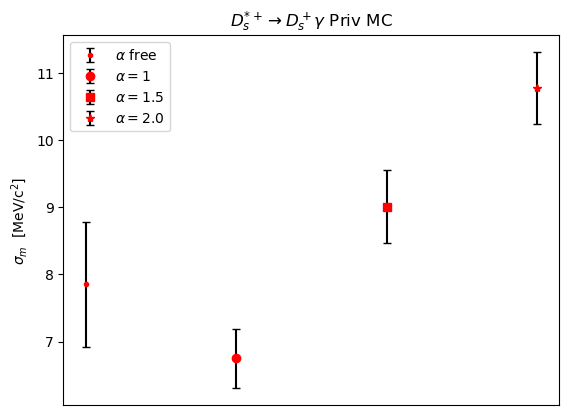

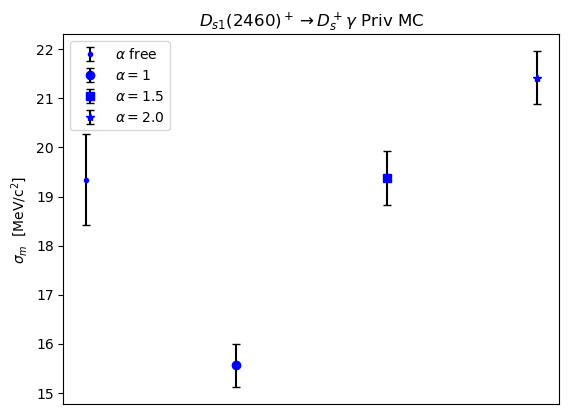

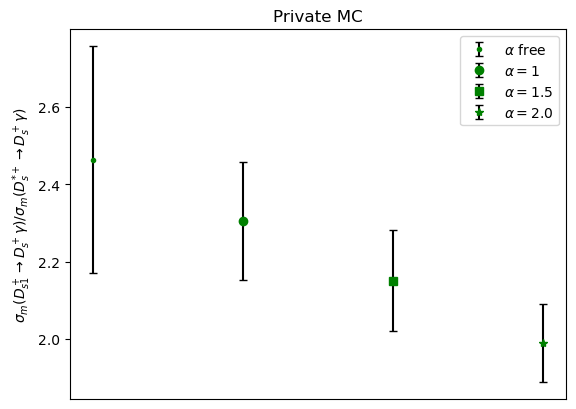

In [23]:
sigma_mass_sel_nf_a = np.array([7.85, 19.34])
usigma_mass_sel_nf_a = np.array([0.93, 0.47])

sigma_mass_sel_f10_a = np.array([6.7487  , 15.557])
usigma_mass_sel_f10_a = np.array([0.443111, 0.371298])

sigma_mass_sel_f15_a = np.array([9.010270, 19.3809])
usigma_mass_sel_f15_a = np.array([0.544824, 0.371932])

sigma_mass_sel_f20_a = np.array([10.77, 21.4238])
usigma_mass_sel_f20_a = np.array([0.537754, 0.357464])

Dsst_sigmas = np.array([sigma_mass_sel_nf_a[0], sigma_mass_sel_f10_a[0], sigma_mass_sel_f15_a[0], sigma_mass_sel_f20_a[0]])
uDsst_sigmas = np.array([usigma_mass_sel_nf_a[0], usigma_mass_sel_f10_a[0], usigma_mass_sel_f15_a[0], usigma_mass_sel_f20_a[0]])

Ds1_sigmas = np.array([sigma_mass_sel_nf_a[1], sigma_mass_sel_f10_a[1], sigma_mass_sel_f15_a[1], sigma_mass_sel_f20_a[1]])
uDs1_sigmas = np.array([usigma_mass_sel_nf_a[1], usigma_mass_sel_f10_a[1], usigma_mass_sel_f15_a[1], usigma_mass_sel_f20_a[1]])

def u_coef(x, y, ux, uy):
    ucoef = np.sqrt((ux/x)**2+(uy*x/y**2)**2)
    return ucoef

xvals = np.array([0.5, 1, 1.5, 2])
labels = [r"$\alpha$ free", r"$\alpha=1$", r"$\alpha=1.5$", r"$\alpha=2.0$"]
fmts = [".", "o", "s", "*"]

plt.figure(1)
for i in range(len(xvals)):
    plt.errorbar(xvals[i], Dsst_sigmas[i], uDsst_sigmas[i], fmt=fmts[i], color="red", capsize=3, ecolor="black", label=labels[i])
plt.ylabel(r"$\sigma_m$  $[\mathrm{MeV/c^2}]$")
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.legend()
plt.title(r"$D_s^{*+} \to D_s^+ \gamma$ Priv MC")
plt.savefig("Graphs/Sim_DsgL_Dsst_sig_sigma_vs_alpha_CB.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
for i in range(len(xvals)):
    plt.errorbar(xvals[i], Ds1_sigmas[i], uDsst_sigmas[i], fmt=fmts[i], color="blue", capsize=3, ecolor="black", label=labels[i])
plt.ylabel(r"$\sigma_m$  $[\mathrm{MeV/c^2}]$")
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.legend()
plt.title(r"$D_{s1}(2460)^+ \to D_s^+ \gamma$ Priv MC")
plt.savefig("Graphs/Sim_DsgL_Ds1_sig_sigma_vs_alpha_CB.pdf", dpi=300, bbox_inches='tight')

plt.figure(3)
for i in range(len(xvals)):
    plt.errorbar(xvals[i], Ds1_sigmas[i]/Dsst_sigmas[i], 
                 u_coef(Ds1_sigmas[i], Dsst_sigmas[i], uDs1_sigmas[i], uDsst_sigmas[i]), fmt=fmts[i], color="green", capsize=3, ecolor="black", label=labels[i])
plt.ylabel(r"$\sigma_m(D_{s1}^+\to D_s^+\gamma) / \sigma_m(D_{s}^{*+}\to D_s^+\gamma)$")
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
plt.legend()
plt.title(r"Private MC")
plt.savefig("Graphs/Sim_Comp_DsgL_sigma_coeff_vs_alpha_CB.pdf", dpi=300, bbox_inches='tight')
